In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import glob
from scipy.special import exp1,factorial
from scipy.stats import binom,nbinom
from scipy.special import gammaln
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from scipy.interpolate import griddata

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
### Functions for theory

def get_lc(sigma,s):
    return np.sqrt(sigma**2/s)

def get_lambda_theory(w,sigma,s):
    lc = get_lc(sigma,s)
    term = (w / lc) ** 2
    if term <= 800:
        prod_term = np.exp(term) * exp1(term)
    else:
        prod_term = sum((factorial(k) / (-term)**k for k in range(7))) / term
    return (4*np.pi)/prod_term

def get_EP_theory(mu, s):
    return mu / s

def get_EPsquared_theory(mu, s, rho, sigma, w):
    lcs = get_lc(sigma, s)**2
    term = (w / np.sqrt(lcs)) ** 2
    if term <= 800:
        prod_term = np.exp(term) * exp1(term)
    else:
        prod_term = sum((factorial(k) / (-term)**k for k in range(7))) / term
    return (mu / (s ** 2 * rho * 4 * np.pi * lcs)) * prod_term + mu ** 2 / s ** 2

def get_sfs_theory(x,n,mu,s,rho,sigma,w):
    mean = get_EP_theory(mu,s)
    var = get_EPsquared_theory(mu,s,rho,sigma,w) - mean**2
    alpha = mean**2/var
    beta = mean/var
    return nbinom.pmf(x,alpha,beta/(beta+n))

def get_sfs_theory_unif(x,n,mu,s,N):
    mean = mu/s
    var = mu/(s*s*N)
    alpha = mean**2/var
    beta = mean/var
    return nbinom.pmf(x,alpha,beta/(beta+n))

### Comparison between theory and data

In [3]:
### Scale factors for y axis - from empiriaclplots_v20250217

len_syn = 1308.0216666666665
len_mis = 2616.043333333333
len_lof = 167.616

prop_kept_syn = 32320/247378
prop_kept_mis = 32320/505963
prop_kept_lof = 1

Optimize using one value of w... 

In [4]:
### Function 

def get_obs_dist(width,vartype,scale_factor,centers): # return counts: scale factor should be equal to prop_kept
    obs_dist_list = []
    if width is not None: # not uniform
        for center in centers: # average over centers
            sfs = pd.read_csv(f'../empirical/subsampling_SIR_v20250127/results/sfs/chr1_{vartype}_{center}geo{width}_nSIR10000_nSIRreps10.SIRsfs', sep=' ')
            sfs_grouped = sfs.groupby('OBS_N')['COUNT_SITES'].agg(['mean', 'std']) # average over replicates
            obs_dist_temp = sfs_grouped['mean'] / scale_factor # scale to adjust for downsampling
            obs_dist_list.append(obs_dist_temp)
        obs_dist = np.mean(obs_dist_list,axis=0)
    else: # uniform
        sfs = pd.read_csv(f'../empirical/subsampling_SIR_v20250127/results/sfs/chr1_{vartype}_uniformgeo_nSIR10000_nSIRreps10.SIRsfs', sep=' ')
        sfs_grouped = sfs.groupby('OBS_N')['COUNT_SITES'].agg(['mean', 'std']) # average over replicates
        obs_dist = sfs_grouped['mean'] / scale_factor # scale to adjust for downsampling
    return obs_dist

### Function to compare observed (data) to expected (theory) sfs and return log likelihood

def comp_logl(nb_dist,width,vartype,scale_factor,centers=['centerE9N9','centerE16N4','centerE6N4'],min_x=1,max_x=10):
    obs_dist = get_obs_dist(width,vartype,scale_factor,centers)
    obs_dist = obs_dist[min_x:max_x+1]
    # log likelihood calculation log L = sum(OlogE-E-logO!)
    logl = np.sum(obs_dist * np.log(nb_dist) - nb_dist - gammaln(obs_dist + 1))  #log gamma is numerically stable implementation of log(O!)
    return logl

### Function for grid search

def grid_search(sigma_list,rho_list,s_list,w_list,mu_list,width,vartype,scale_factor,L_scale,max_x=10,min_x=1):
    logl_results = []
    n=10000
    for sigma in sigma_list:
        for rho in rho_list:
            for s in s_list:
                for w in w_list:
                    for mu in mu_list:
                        # nb dist needs to be counts - theory returns bp - convert to kb with *1000 and then to length of appropriate region with L_scale (in kb)
                        nb_dist = np.array([get_sfs_theory(y, n, mu, s, rho, sigma, w)*L_scale*1000 for y in np.arange(min_x, max_x+1)])
                        logl = comp_logl(nb_dist,width,vartype,scale_factor,min_x=min_x,max_x=max_x)
                        logl_results.append((sigma,rho,s,w,mu,logl))
    logl_results.sort(key=lambda x:x[5],reverse=True)
    return logl_results

### Function for grid search - 2 w

def grid_search_multiw(sigma_list,rho_list,s_list,w_list,mu_list,widths,vartype,scale_factor,L_scale,max_x=10,min_x=1):
    assert len(w_list) == len(widths), "w_list and width_list must be the same length"
    logl_results = []
    n=10000
    for sigma in sigma_list:
        for rho in rho_list:
            for s in s_list:
                for mu in mu_list:
                    logl_sum = 0
                    for i,w in enumerate(w_list):
                        # nb dist needs to be counts - theory returns bp - convert to kb with *1000 and then to length of appropriate region with L_scale (in kb)
                        nb_dist = np.array([get_sfs_theory(y, n, mu, s, rho, sigma, w)*L_scale*1000 for y in np.arange(min_x, max_x+1)])
                        logl_sum += comp_logl(nb_dist,widths[i],vartype,scale_factor,min_x=min_x,max_x=max_x)
                    logl_results.append((sigma,rho,s,'multi',mu,logl_sum))
    logl_results.sort(key=lambda x:x[5],reverse=True)
    return logl_results

### Function to print grid search results

def print_res(results,vt,max_rank=20):
    print(f"Ranking of parameter combinations by best fit (highest logL), {vt} variants:")
    for rank, (sigma, rho, s, w, mu, logl) in enumerate(results, 1):
        if rank<=max_rank:
            print(f"{rank}. sigma={sigma}, rho={rho}, s={s:.1e}, w={w}, mu={mu:.2e}, logl={logl:.5f}")

### Plotting function -sfs

def plot_data_vs_theory(sigma, rho, s, mu=1.25e-8, n=10000, centers=['centerE9N9','centerE16N4','centerE6N4'],
                        widths_data=['50000','100000','150000',None], vartypes=['synonymous','missense','lof'],
                        scale_factors=[prop_kept_syn, prop_kept_mis, 1], maxval=50):
    colors = ['steelblue', 'orchid', 'darkorange']
    widths_theory = [50, 100, 150, 500]
    Lscale = [len_syn, len_mis, len_lof]
    
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    x = np.logspace(0, 2)
    y = x**-1

    for i in [0, 1, 2, 3]:
        ax[i].loglog(x, y, color='lightgray', linestyle='--')
        ax[i].loglog(x, y * 10, color='lightgray', linestyle='--')
        ax[i].loglog(x, y * 100, color='lightgray', linestyle='--')
        ax[i].loglog(x, y / 100, color='lightgray', linestyle='--')
        ax[i].loglog(x, y / 10, color='lightgray', linestyle='--')

    for j, w in enumerate(widths_theory):
        nb_dist = [get_sfs_theory(y, n, mu, s, rho, sigma, w) * 1000 for y in np.arange(0, maxval)] # plot per kb
        ax[j].loglog(np.arange(0, maxval), nb_dist, marker=None, linestyle='-', linewidth=1, alpha=1, color='black', label=f'theory')

    for j, wid in enumerate(widths_data):
        for i, vt in enumerate(vartypes):
            sfs = get_obs_dist(wid, vt, scale_factors[i], centers=centers)
            sfs_kb = [x / Lscale[i] for x in sfs] # plot per kb
            ax[j].loglog(np.arange(0, maxval), sfs_kb[:maxval], marker='x', color=colors[i], linestyle='', label=vartypes[i])

    for i in [0, 1, 2, 3]:
        ax[i].set_ylim(1e-3, 1e2)
        ax[i].legend()

    ax[0].set_title('w=50km')
    ax[1].set_title('w=100km')
    ax[2].set_title('w=150km')
    ax[3].set_title('uniform')

    plt.show()

## Plotting function - heatmap

def plot_log_likelihood(res_df):
    res_df['rho'] = res_df['rho'].round(2)
    res_df['sigma'] = res_df['sigma'].round(2)
    
    filtered_data = res_df.loc[res_df.groupby(['sigma', 'rho'])['logl'].idxmax()]
    heatmap_data = filtered_data.pivot(index='rho', columns='sigma', values='logl')
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_data, annot=False, cmap="plasma", fmt=".2f", annot_kws={"size": 6})
    plt.xlabel("Sigma")
    plt.ylabel("Rho")
    plt.title('log likelihood - Poisson')
    plt.show()



def plot_log_likelihood_contour(res_df):
    res_df['rho'] = res_df['rho'].round(2)
    res_df['sigma'] = res_df['sigma'].round(2)
    
    filtered_data = res_df.loc[res_df.groupby(['sigma', 'rho'])['logl'].idxmax()]
    
    # Prepare the grid for contour plot
    rho_vals = np.unique(filtered_data['rho'])
    sigma_vals = np.unique(filtered_data['sigma'])
    
    # Create a meshgrid for contour plot
    Rho, Sigma = np.meshgrid(rho_vals, sigma_vals)
    LogL = filtered_data.pivot(index='rho', columns='sigma', values='logl').values
    
    # Define contour levels
    logl_min = LogL.min()
    logl_max = LogL.max()
    contour_levels = np.linspace(logl_min, logl_max, 20)
    
    plt.figure(figsize=(8, 6))
    cp = plt.contourf(Sigma, Rho, LogL, cmap="plasma", levels=contour_levels)
    plt.colorbar(cp, label='Log Likelihood')
    plt.xlabel("Sigma")
    plt.ylabel("Rho")
    plt.title('Log Likelihood Contour Plot - Poisson')
    
    # Flip the y-axis (Rho) order
    plt.gca().invert_yaxis()
    
    plt.show()


['50000', '100000', '150000']

In [5]:
sigma_list = np.linspace(1,500,50)#(1,30,30)
rho_list = np.linspace(0.1,10,30)
s_list = np.logspace(-4,-2,30)
w_list = [50]
mu_list = [1.25e-8]
width = '50000'
vartype = 'missense'
scale_factor = prop_kept_mis
L_scale = len_mis

One value of w...

In [9]:
res_minx1 = grid_search(sigma_list,rho_list,s_list,w_list,mu_list,width,vartype,scale_factor,L_scale,max_x=10)
# print_res(res,'missense')
res_minx1 = pd.DataFrame(res_minx1,columns=['sigma','rho','s','w','mu','logl'])
res_minx1.to_csv("res_w50_minx1_sigma500.csv", index=False)

In [10]:
res_minx2 = grid_search(sigma_list,rho_list,s_list,w_list,mu_list,width,vartype,scale_factor,L_scale,min_x=2,max_x=10)
res_minx2 = pd.DataFrame(res_minx2,columns=['sigma','rho','s','w','mu','logl'])
res_minx2.to_csv("res_w50_minx2_sigma500.csv", index=False)

In [11]:
res_minx3 = grid_search(sigma_list,rho_list,s_list,w_list,mu_list,width,vartype,scale_factor,L_scale,min_x=3,max_x=10)
res_minx3 = pd.DataFrame(res_minx3,columns=['sigma','rho','s','w','mu','logl'])
res_minx3.to_csv("res_w50_minx3_sigma500.csv", index=False)

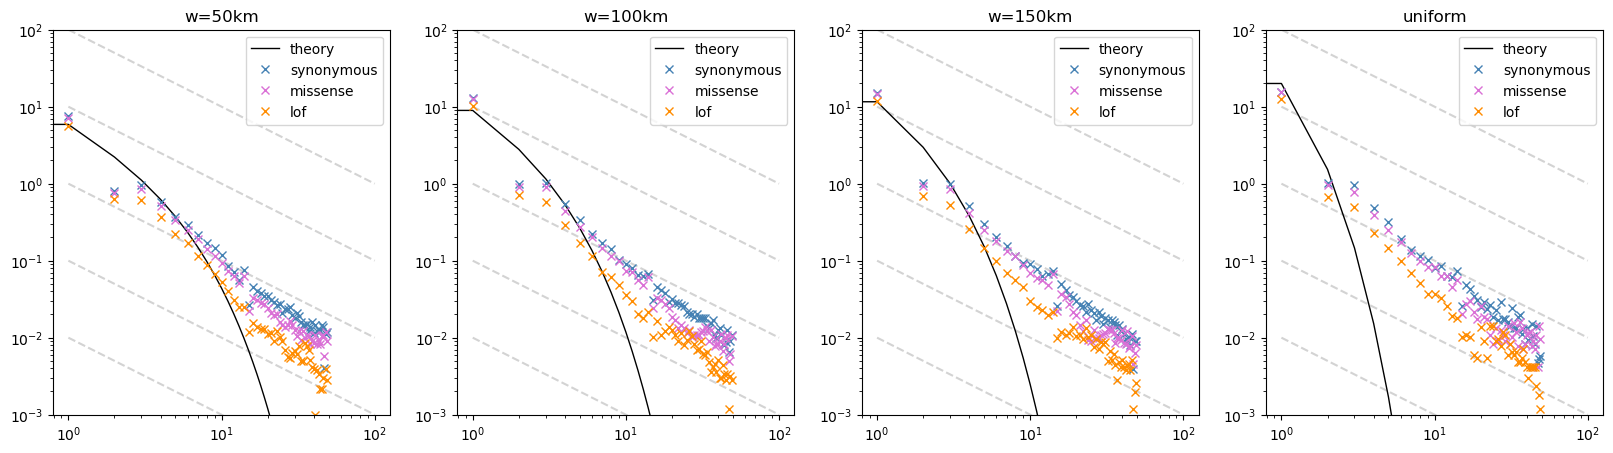

In [89]:
plot_data_vs_theory(13,3.5138,5.3e-3)

In [30]:
res_df = pd.DataFrame(res,columns=['sigma','rho','s','w','mu','logl'])
plot_log_likelihood(res_df)
res_df.to_csv("res1.csv", index=False)

NameError: name 'res' is not defined

In [38]:
res_df

NameError: name 'res_df' is not defined

Two values of w...

In [24]:
widths = ['50000','100000']
w_list = [50,100]
# res2 = grid_search_multiw(sigma_list,rho_list,s_list,w_list,mu_list,widths,vartype,scale_factor,L_scale,max_x=10)
# print_res(res2,'missense')

In [25]:
res2_minx1 = grid_search_multiw(sigma_list,rho_list,s_list,w_list,mu_list,widths,vartype,scale_factor,L_scale,min_x=1,max_x=10)
res2_minx1 = pd.DataFrame(res2_minx1,columns=['sigma','rho','s','w','mu','logl'])
# res2_minx1.to_csv("res_w50_w100_minx1_sigma500.csv", index=False)

KeyboardInterrupt: 

In [14]:
res2_minx2 = grid_search_multiw(sigma_list,rho_list,s_list,w_list,mu_list,widths,vartype,scale_factor,L_scale,min_x=2,max_x=10)
res2_minx2 = pd.DataFrame(res2_minx2,columns=['sigma','rho','s','w','mu','logl'])
res2_minx2.to_csv("res_w50_w100_minx2_sigma500.csv", index=False)

In [15]:
res2_minx3 = grid_search_multiw(sigma_list,rho_list,s_list,w_list,mu_list,widths,vartype,scale_factor,L_scale,min_x=3,max_x=10)
res2_minx3 = pd.DataFrame(res2_minx3,columns=['sigma','rho','s','w','mu','logl'])
res2_minx3.to_csv("res_w50_w100_minx3_sigma500.csv", index=False)

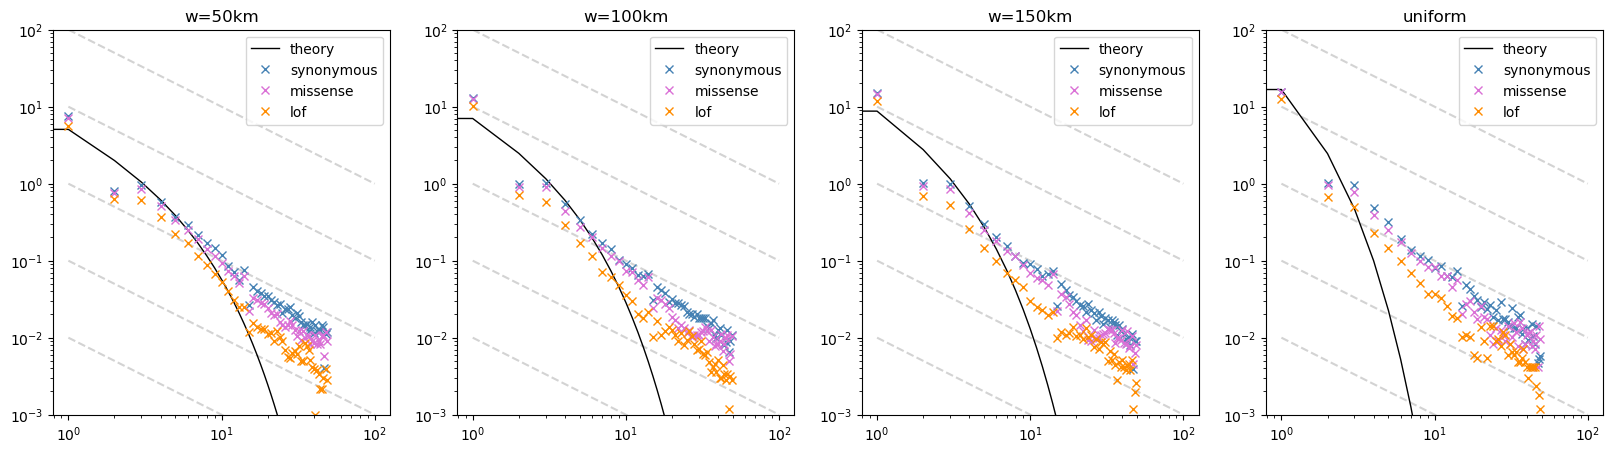

In [88]:
plot_data_vs_theory(26.0,1.124,5.3e-3)

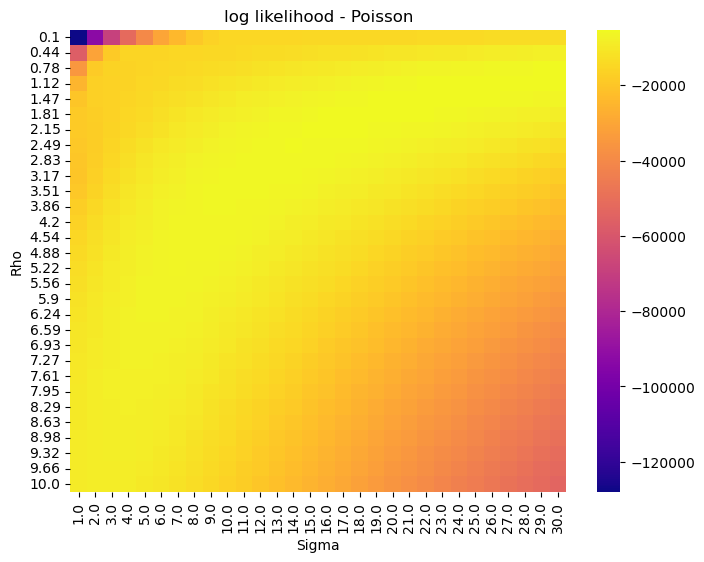

In [110]:
res_df2 = pd.DataFrame(res2,columns=['sigma','rho','s','w','mu','logl'])
plot_log_likelihood(res_df2)
res_df2.to_csv("res2.csv", index=False)

3 values...

In [78]:
widths = ['50000','100000','150000']
w_list = [50,100,150]
# res3 = grid_search_multiw(sigma_list,rho_list,s_list,w_list,mu_list,widths,vartype,scale_factor,L_scale,max_x=10)
# print_res(res3,'missense')
vartype = 'missense'
sigma_list = np.linspace(1,500,50)#(1,30,30)
rho_list = np.linspace(0.0001,7.5,50)
s_list = np.logspace(-4,-1,40)

In [79]:
res3_minx1 = grid_search_multiw(sigma_list,rho_list,s_list,w_list,mu_list,widths,vartype,scale_factor,L_scale,min_x=1,max_x=10)
res3_minx1 = pd.DataFrame(res3_minx1,columns=['sigma','rho','s','w','mu','logl'])
res3_minx1.to_csv("res_w50_w100_w150_minx1_sigma500_rho7.5.csv", index=False)

In [80]:
res3_minx2 = grid_search_multiw(sigma_list,rho_list,s_list,w_list,mu_list,widths,vartype,scale_factor,L_scale,min_x=2,max_x=10)
res3_minx2 = pd.DataFrame(res3_minx2,columns=['sigma','rho','s','w','mu','logl'])
res3_minx2.to_csv("res_w50_w100_w150_minx2_sigma500_rho7.5.csv", index=False)

In [81]:
res3_minx3 = grid_search_multiw(sigma_list,rho_list,s_list,w_list,mu_list,widths,vartype,scale_factor,L_scale,min_x=3,max_x=10)
res3_minx3 = pd.DataFrame(res3_minx3,columns=['sigma','rho','s','w','mu','logl'])
res3_minx3.to_csv("res_w50_w100_w150_minx3_sigma500_rho7.5.csv", index=False)

In [71]:
res3_minx3['s'].min()

0.0001

In [72]:
res3_minx3['s'].max()

0.01

In [36]:
res3_minx3

,sigma,rho,s,w,mu,logl
0,62.102041,0.138028,0.005298,multi,1.250000e-08,-73.297210
1,41.734694,0.275955,0.005298,multi,1.250000e-08,-76.654311
2,72.285714,0.138028,0.005298,multi,1.250000e-08,-78.720246
3,31.551020,0.413883,0.005298,multi,1.250000e-08,-79.040070
4,51.918367,0.138028,0.004520,multi,1.250000e-08,-80.689989
...,...,...,...,...,...,...
44995,82.469388,0.689738,0.000100,multi,1.250000e-08,-79195.050342
44996,92.653061,0.551810,0.000100,multi,1.250000e-08,-79205.234616
44997,194.489796,0.138028,0.000100,multi,1.250000e-08,-79209.430254
44998,133.387755,0.275955,0.000100,multi,1.250000e-08,-79209.634797


In [37]:
res3_minx2

,sigma,rho,s,w,mu,logl
0,41.734694,0.138028,0.004520,multi,1.250000e-08,-144.134901
1,479.632653,0.000100,0.000189,multi,1.250000e-08,-149.448923
2,449.081633,0.000100,0.000161,multi,1.250000e-08,-149.855137
3,408.346939,0.000100,0.000137,multi,1.250000e-08,-149.983476
4,489.816327,0.000100,0.000189,multi,1.250000e-08,-149.989050
...,...,...,...,...,...,...
44995,489.816327,3.862072,0.000100,multi,1.250000e-08,-171335.849014
44996,500.000000,3.724145,0.000100,multi,1.250000e-08,-171336.245623
44997,489.816327,4.000000,0.000100,multi,1.250000e-08,-171345.873523
44998,500.000000,3.862072,0.000100,multi,1.250000e-08,-171346.614269


In [38]:
res3_minx1

,sigma,rho,s,w,mu,logl
0,92.653061,0.138028,0.005298,multi,1.250000e-08,-571.487015
1,102.836735,0.138028,0.006210,multi,1.250000e-08,-572.806458
2,102.836735,0.138028,0.005298,multi,1.250000e-08,-581.351103
3,62.102041,0.275955,0.005298,multi,1.250000e-08,-583.050357
4,113.020408,0.138028,0.006210,multi,1.250000e-08,-584.273997
...,...,...,...,...,...,...
44995,489.816327,3.862072,0.000100,multi,1.250000e-08,-332992.682377
44996,500.000000,3.724145,0.000100,multi,1.250000e-08,-332994.001958
44997,489.816327,4.000000,0.000100,multi,1.250000e-08,-333026.031335
44998,500.000000,3.862072,0.000100,multi,1.250000e-08,-333028.495488


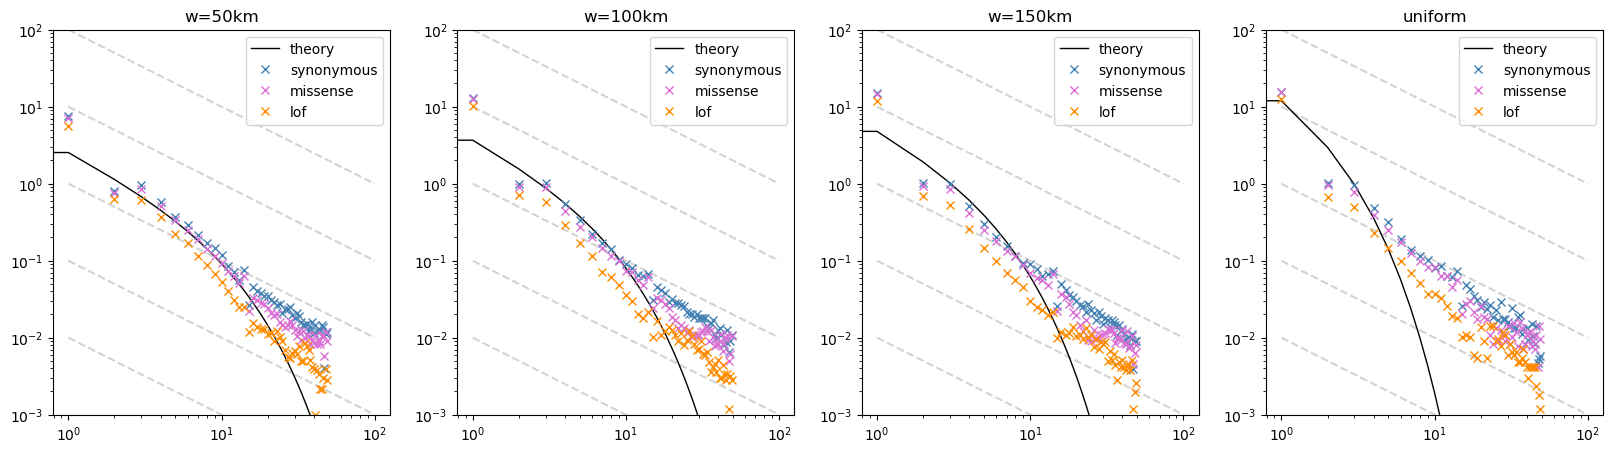

In [26]:
plot_data_vs_theory(28,0.441379,5.3e-3)

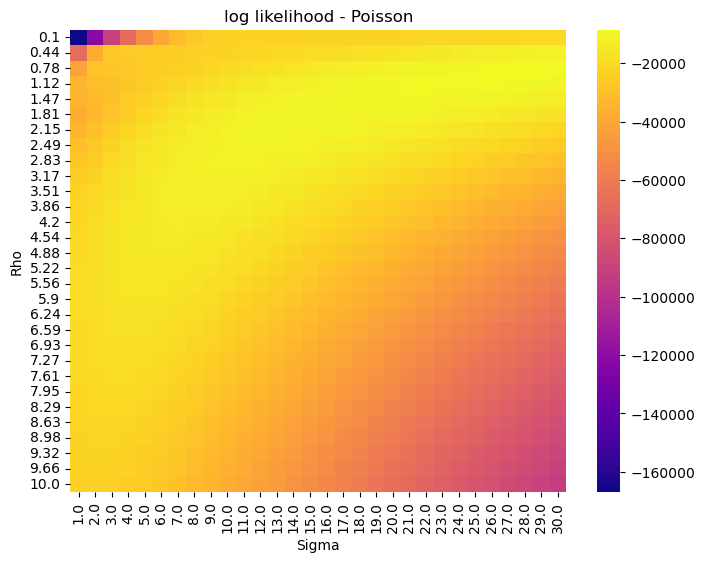

In [111]:
res_df3 = pd.DataFrame(res3,columns=['sigma','rho','s','w','mu','logl'])
plot_log_likelihood(res_df3)
res_df3.to_csv("res3.csv", index=False)

### LoFs

In [7]:
# sigma_list = np.linspace(1,30,30)
# rho_list = np.linspace(0.1,10,30)
s_list = np.logspace(-4,-1,40)
mu_list = [1.25e-8]
widths = ['50000','100000','150000']
w_list = [50,100,150]
vartype = 'lof'
scale_factor = prop_kept_lof
L_scale = len_lof

In [8]:
# min_x=1
sigma_list = [11.183673469387756, 51.91836734693878, 62.102040816326536]
rho_list = [4.285757142857142, 0.1531591836734693, 0.1531591836734693]
lof_min1 = grid_search_multiw([sigma_list[0]],[rho_list[0]],s_list,w_list,mu_list,widths,vartype,scale_factor,L_scale,min_x=1,max_x=10)

In [73]:
# lof_min1

In [9]:
lof_min1_df = pd.DataFrame(lof_min1,columns=['sigma','rho','s','w','mu','logl'])

In [5]:
# lof_min1_df

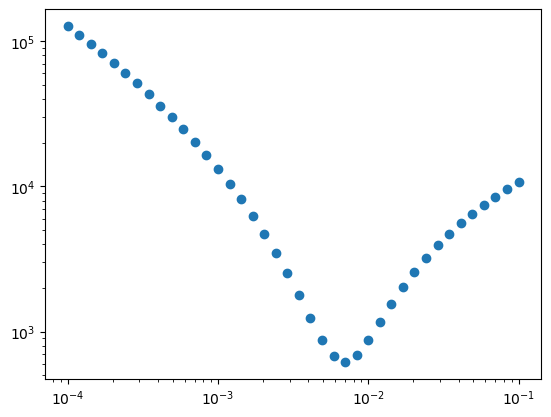

In [10]:
plt.scatter(lof_min1_df['s'],-1*lof_min1_df['logl'])
plt.yscale('log')
plt.xscale('log')

In [14]:
lof_min1_df.to_csv('lof_min1.csv',index=False)
lof_min2_df.to_csv('lof_min2.csv',index=False)
lof_min3_df.to_csv('lof_min3.csv',index=False)

In [11]:
# min_x=2
lof_min2 = grid_search_multiw([sigma_list[1]],[rho_list[1]],s_list,w_list,mu_list,widths,vartype,scale_factor,L_scale,min_x=2,max_x=10)
lof_min2_df = pd.DataFrame(lof_min2,columns=['sigma','rho','s','w','mu','logl'])
lof_min2_df  

,sigma,rho,s,w,mu,logl
0,51.918367,0.153159,0.010000,multi,1.250000e-08,-103.621511
1,51.918367,0.153159,0.011938,multi,1.250000e-08,-114.097281
2,51.918367,0.153159,0.008377,multi,1.250000e-08,-119.121627
3,51.918367,0.153159,0.014251,multi,1.250000e-08,-147.153859
4,51.918367,0.153159,0.007017,multi,1.250000e-08,-164.646590
5,51.918367,0.153159,0.017013,multi,1.250000e-08,-199.965639
6,51.918367,0.153159,0.005878,multi,1.250000e-08,-244.999135
7,51.918367,0.153159,0.020309,multi,1.250000e-08,-270.205408
8,51.918367,0.153159,0.024245,multi,1.250000e-08,-355.984706
9,51.918367,0.153159,0.004924,multi,1.250000e-08,-365.853522


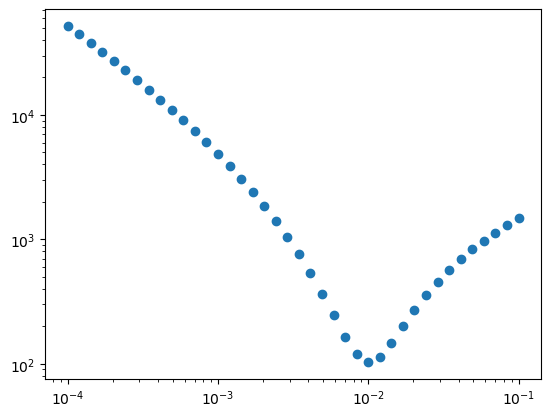

In [12]:
plt.scatter(lof_min2_df['s'],-1*lof_min2_df['logl'])
plt.yscale('log')
plt.xscale('log')

In [13]:
# min_x=3
lof_min3 = grid_search_multiw([sigma_list[2]],[rho_list[2]],s_list,w_list,mu_list,widths,vartype,scale_factor,L_scale,min_x=3,max_x=10)
lof_min3_df = pd.DataFrame(lof_min3,columns=['sigma','rho','s','w','mu','logl'])
lof_min3_df  

,sigma,rho,s,w,mu,logl
0,62.102041,0.153159,0.010000,multi,1.250000e-08,-73.148218
1,62.102041,0.153159,0.008377,multi,1.250000e-08,-82.365900
2,62.102041,0.153159,0.011938,multi,1.250000e-08,-85.013767
3,62.102041,0.153159,0.014251,multi,1.250000e-08,-115.180661
4,62.102041,0.153159,0.007017,multi,1.250000e-08,-116.004022
5,62.102041,0.153159,0.017013,multi,1.250000e-08,-161.346279
6,62.102041,0.153159,0.005878,multi,1.250000e-08,-178.045386
7,62.102041,0.153159,0.020309,multi,1.250000e-08,-221.623325
8,62.102041,0.153159,0.004924,multi,1.250000e-08,-273.225228
9,62.102041,0.153159,0.024245,multi,1.250000e-08,-294.486229


# All Summary Plots

In [178]:
def plot_log_likelihood_v2(res_df):
    res_df['rho'] = res_df['rho'].round(2)
    res_df['sigma'] = res_df['sigma'].round(2)
    
    filtered_data = res_df.loc[res_df.groupby(['sigma', 'rho'])['logl'].idxmax()]
    
    # Prepare the grid for heatmap and contour plot
    rho_vals = np.unique(filtered_data['rho'])
    sigma_vals = np.unique(filtered_data['sigma'])
    
    # Create a meshgrid for the plot
    Sigma, Rho = np.meshgrid(sigma_vals, rho_vals)  # Ensure correct order here
    LogL = filtered_data.pivot(index='rho', columns='sigma', values='logl').values
    
    # Define contour levels
    logl_min = LogL.min()
    logl_max = LogL.max()
    contour_levels = np.linspace(logl_min, logl_max, 30)
    
    plt.figure(figsize=(8, 6))
    
    # Plot heatmap using pcolormesh
    heatmap = plt.pcolormesh(Sigma, Rho, LogL, cmap="plasma", shading='auto')
    plt.colorbar(heatmap, label='Log Likelihood')
    
    # Plot contour lines on top of the heatmap
    contours = plt.contour(Sigma, Rho, LogL, levels=contour_levels, colors='black', linewidths=0.8)
    
    plt.xlabel("Sigma")
    plt.ylabel("Rho")
    plt.title('Log Likelihood Heatmap with Contours - Poisson')
    
    # Flip the y-axis (Rho) order
    plt.gca().invert_yaxis()
    
    plt.show()


## w=50km only

### 1-10tons

In [32]:
res_df=pd.read_csv('res1.csv')
res_df

,sigma,rho,s,w,mu,logl
0,13.0,3.51,0.005298,50,1.250000e-08,-2.360386e+03
1,12.0,3.86,0.005298,50,1.250000e-08,-2.360424e+03
2,14.0,3.17,0.005298,50,1.250000e-08,-2.360526e+03
3,17.0,2.49,0.005298,50,1.250000e-08,-2.360579e+03
4,19.0,2.15,0.005298,50,1.250000e-08,-2.360916e+03
...,...,...,...,...,...,...
26995,29.0,9.66,0.000100,50,1.250000e-08,-1.455954e+06
26996,30.0,9.32,0.000100,50,1.250000e-08,-1.461041e+06
26997,29.0,10.00,0.000100,50,1.250000e-08,-1.463642e+06
26998,30.0,9.66,0.000100,50,1.250000e-08,-1.468887e+06


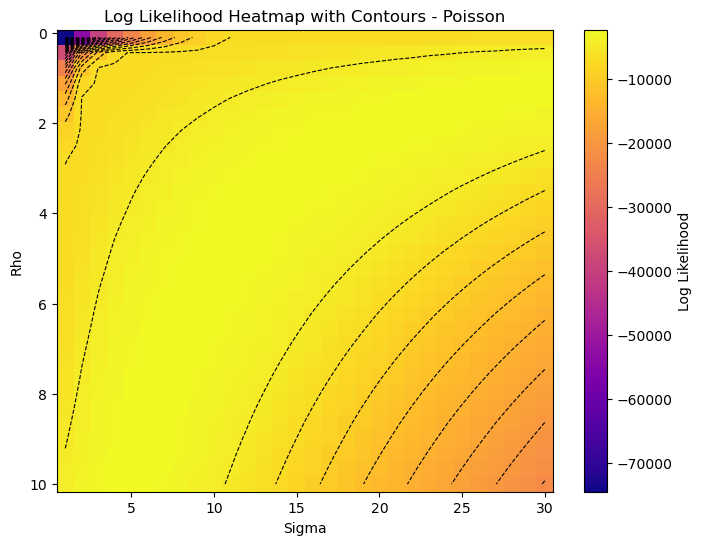

In [168]:
plot_log_likelihood_v2(res_df)

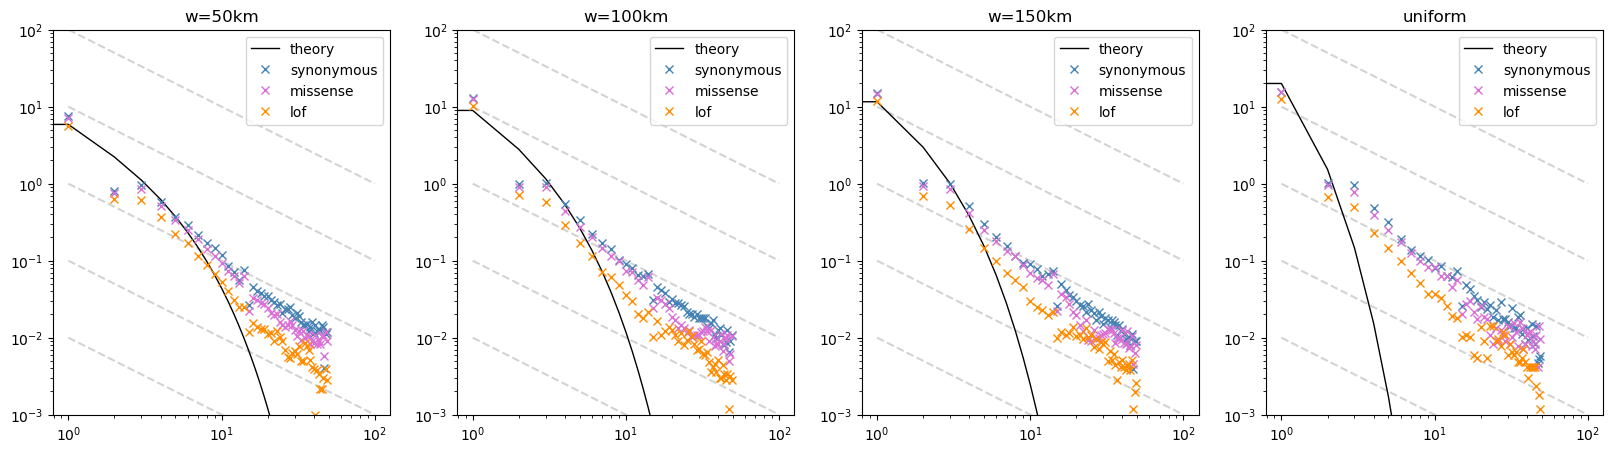

In [156]:
plot_data_vs_theory(13,3.51,0.005298)

### 2-10tons

In [169]:
res_df2=pd.read_csv('res_w50_minx2.csv')
res_df2

,sigma,rho,s,w,mu,logl
0,3.0,3.513793,0.003857,50,1.250000e-08,-266.315487
1,2.0,4.879310,0.004520,50,1.250000e-08,-266.417028
2,23.0,0.441379,0.004520,50,1.250000e-08,-266.606284
3,2.0,4.537931,0.003857,50,1.250000e-08,-266.900401
4,8.0,1.465517,0.003857,50,1.250000e-08,-266.959067
...,...,...,...,...,...,...
26995,29.0,9.658621,0.000100,50,1.250000e-08,-806563.888692
26996,30.0,9.317241,0.000100,50,1.250000e-08,-808251.145180
26997,29.0,10.000000,0.000100,50,1.250000e-08,-809111.322466
26998,30.0,9.658621,0.000100,50,1.250000e-08,-810839.196427


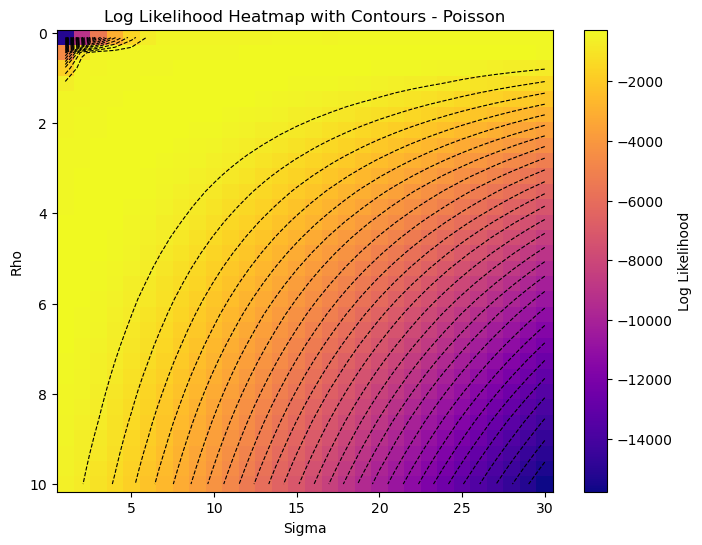

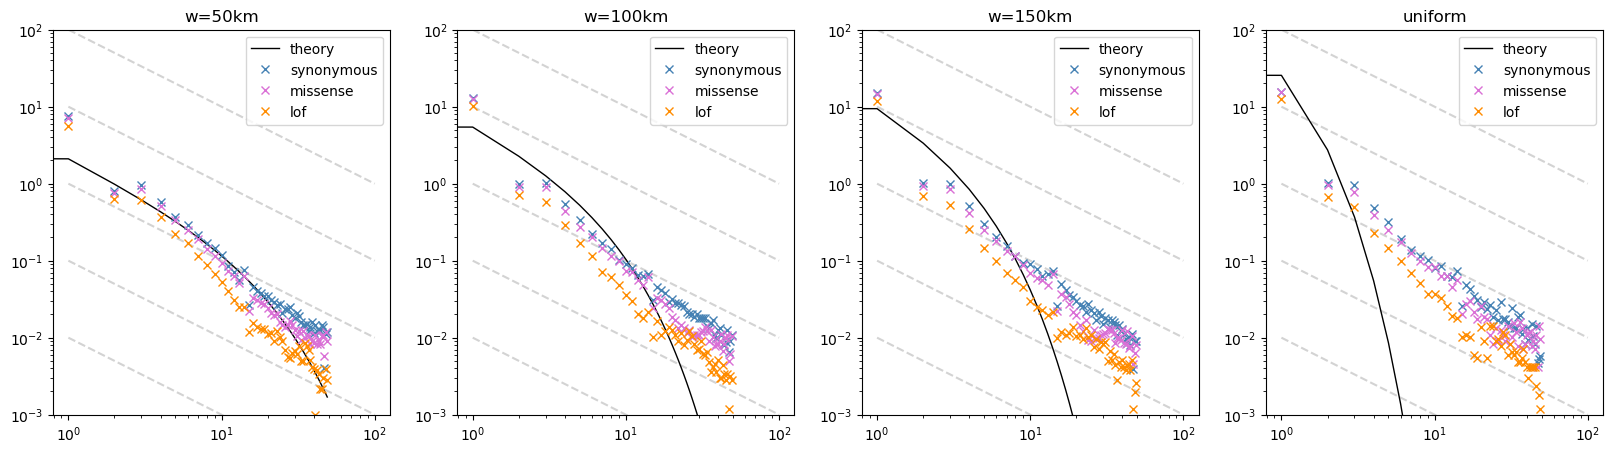

In [170]:
plot_log_likelihood_v2(res_df2)
plot_data_vs_theory(3,3.513793,0.003857)

### 3-10tons

In [37]:
res_df3=pd.read_csv('res_w50_minx3.csv')
res_df3

,sigma,rho,s,w,mu,logl
0,1.0,9.317241,0.005298,50,1.250000e-08,-42.483895
1,4.0,5.562069,0.005298,50,1.250000e-08,-42.496585
2,2.0,7.951724,0.005298,50,1.250000e-08,-42.497505
3,18.0,1.124138,0.005298,50,1.250000e-08,-42.506800
4,7.0,3.513793,0.005298,50,1.250000e-08,-42.533173
...,...,...,...,...,...,...
26995,29.0,4.879310,0.000100,50,1.250000e-08,-412124.457369
26996,30.0,4.537931,0.000100,50,1.250000e-08,-412124.598731
26997,23.0,7.268966,0.000100,50,1.250000e-08,-412125.363595
26998,25.0,6.244828,0.000100,50,1.250000e-08,-412126.091426


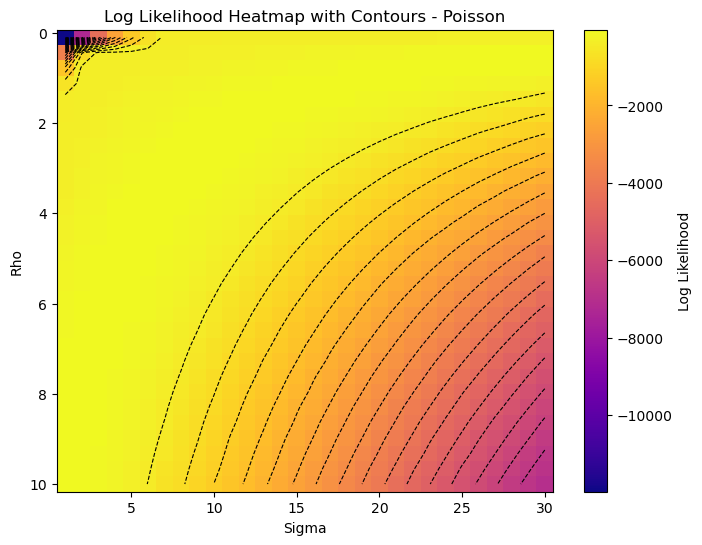

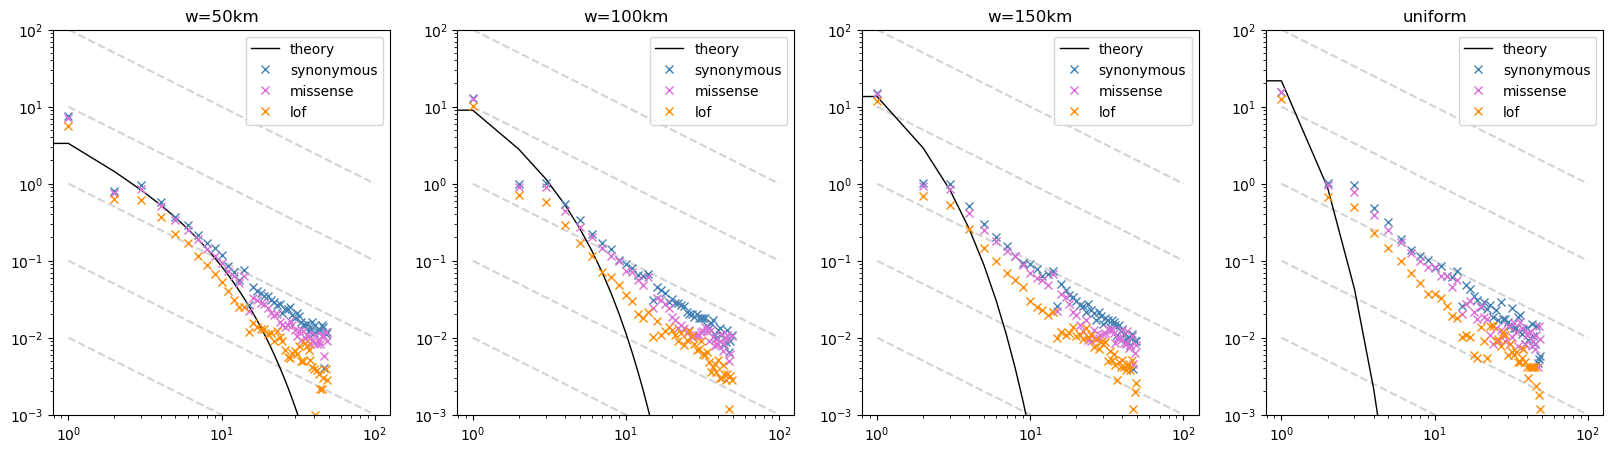

In [171]:
plot_log_likelihood_v2(res_df3)
plot_data_vs_theory(1,9.317241,0.005298)

## w=50km, 100km

### 1-10tons

In [39]:
res2_df1=pd.read_csv('res2.csv')
res2_df1

,sigma,rho,s,w,mu,logl
0,26.0,1.12,0.005298,multi,1.250000e-08,-5.253757e+03
1,25.0,1.12,0.005298,multi,1.250000e-08,-5.269321e+03
2,28.0,1.12,0.006210,multi,1.250000e-08,-5.294648e+03
3,27.0,1.12,0.005298,multi,1.250000e-08,-5.296982e+03
4,29.0,1.12,0.006210,multi,1.250000e-08,-5.301610e+03
...,...,...,...,...,...,...
26995,29.0,9.66,0.000100,multi,1.250000e-08,-2.954283e+06
26996,30.0,9.32,0.000100,multi,1.250000e-08,-2.963449e+06
26997,29.0,10.00,0.000100,multi,1.250000e-08,-2.968700e+06
26998,30.0,9.66,0.000100,multi,1.250000e-08,-2.978164e+06


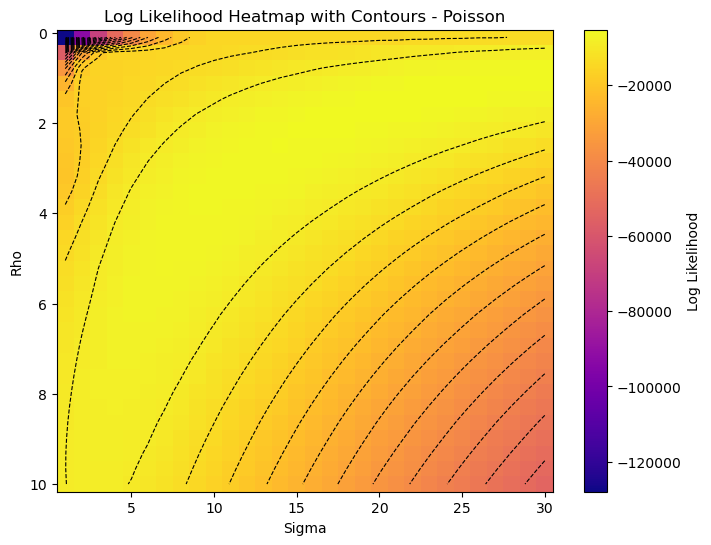

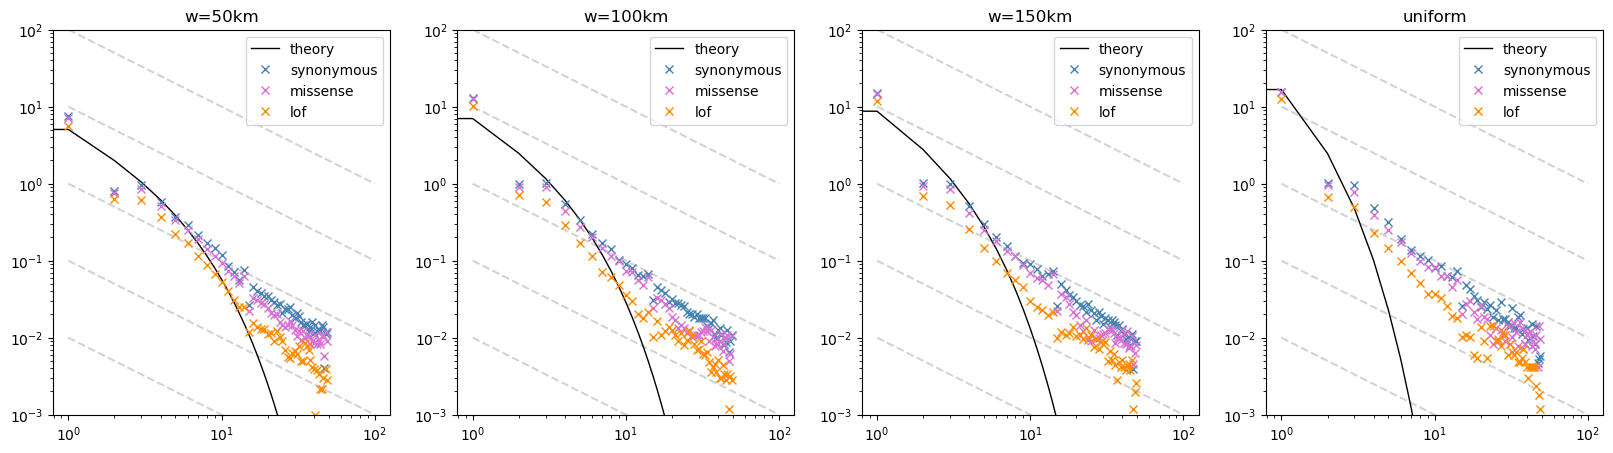

In [172]:
plot_log_likelihood_v2(res2_df1)
plot_data_vs_theory(26,1.12,0.005298)

### 2-10tons

In [41]:
res2_df2=pd.read_csv('res_w50_w100_minx2.csv')
res2_df2

,sigma,rho,s,w,mu,logl
0,20.0,0.441379,0.004520,multi,1.250000e-08,-7.656431e+02
1,23.0,0.441379,0.005298,multi,1.250000e-08,-7.671086e+02
2,22.0,0.441379,0.005298,multi,1.250000e-08,-7.746756e+02
3,21.0,0.441379,0.004520,multi,1.250000e-08,-7.798256e+02
4,24.0,0.441379,0.005298,multi,1.250000e-08,-7.824807e+02
...,...,...,...,...,...,...
26995,29.0,9.658621,0.000100,multi,1.250000e-08,-1.626964e+06
26996,30.0,9.317241,0.000100,multi,1.250000e-08,-1.629958e+06
26997,29.0,10.000000,0.000100,multi,1.250000e-08,-1.631665e+06
26998,30.0,9.658621,0.000100,multi,1.250000e-08,-1.634737e+06


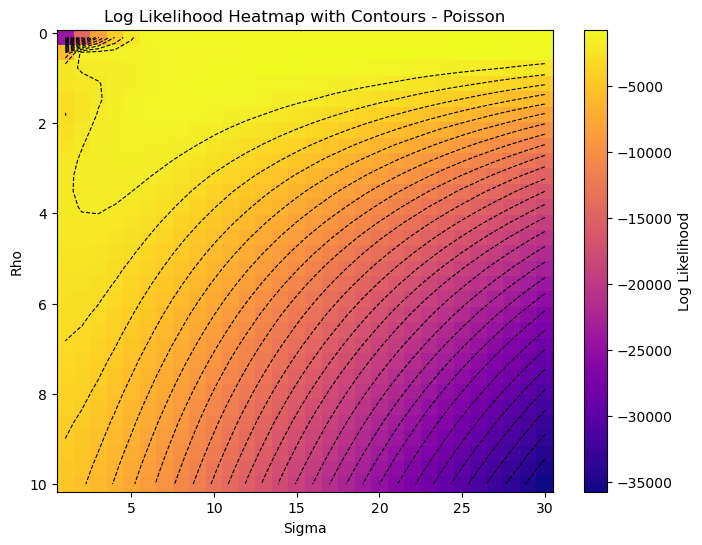

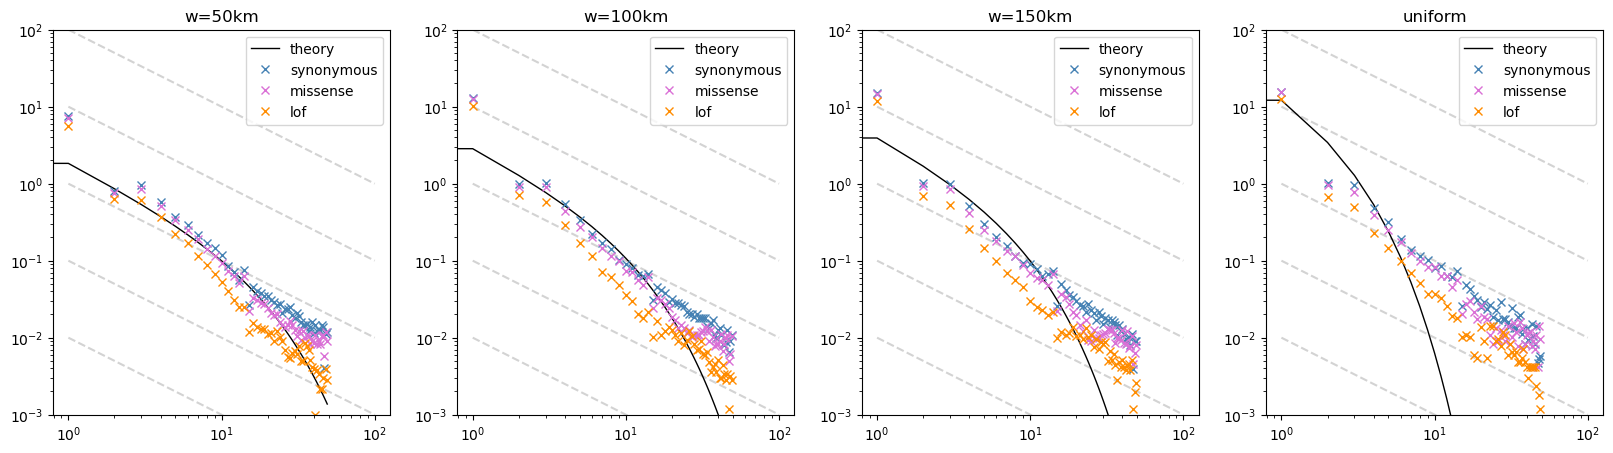

In [173]:
plot_log_likelihood_v2(res2_df2)
plot_data_vs_theory(20,0.441379,0.004520)

### 3-10tons

In [43]:
res2_df3=pd.read_csv('res_w50_w100_minx3.csv')
res2_df3

,sigma,rho,s,w,mu,logl
0,30.0,0.441379,0.005298,multi,1.250000e-08,-133.919547
1,29.0,0.441379,0.005298,multi,1.250000e-08,-142.111322
2,21.0,0.782759,0.005298,multi,1.250000e-08,-153.871400
3,20.0,0.782759,0.005298,multi,1.250000e-08,-154.515470
4,28.0,0.441379,0.005298,multi,1.250000e-08,-156.739614
...,...,...,...,...,...,...
26995,28.0,4.537931,0.000100,multi,1.250000e-08,-823298.437167
26996,26.0,5.220690,0.000100,multi,1.250000e-08,-823315.043982
26997,29.0,4.537931,0.000100,multi,1.250000e-08,-823320.585343
26998,27.0,4.879310,0.000100,multi,1.250000e-08,-823324.552568


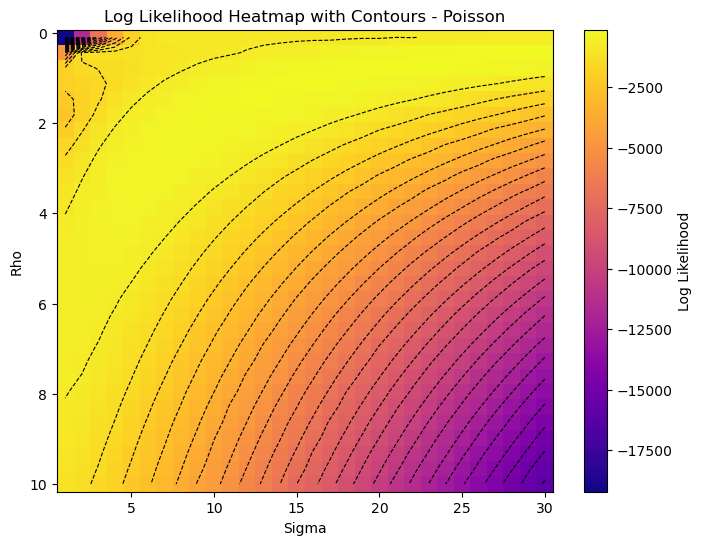

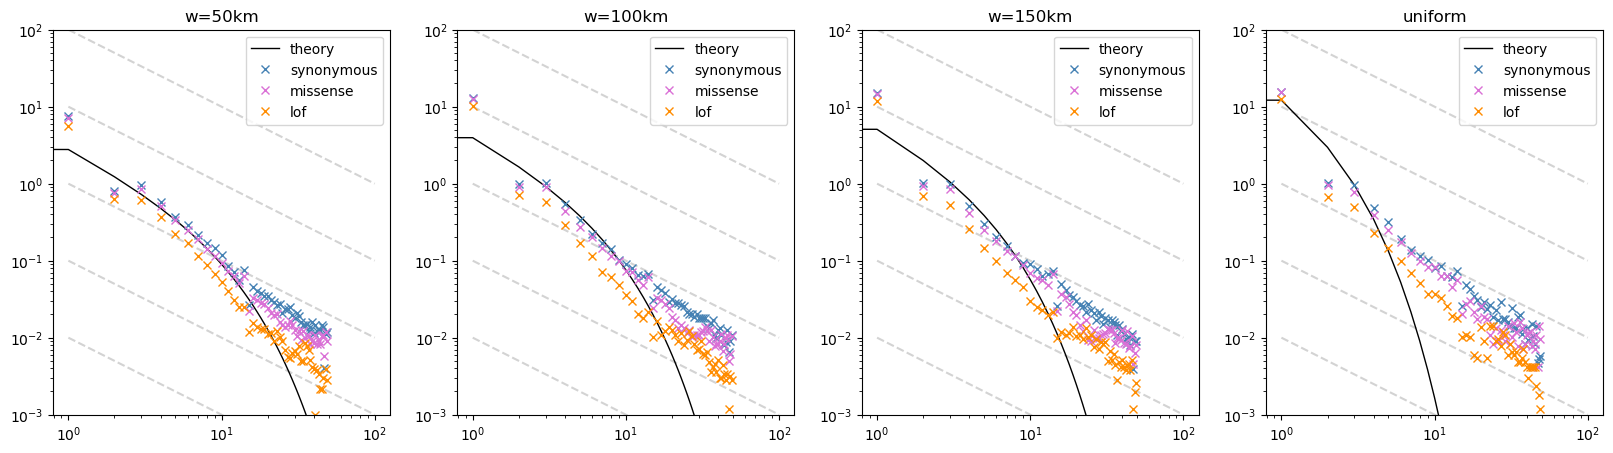

In [174]:
plot_log_likelihood_v2(res2_df3)
plot_data_vs_theory(30,0.441379,0.005298)

## w=50km, 100km, 150km

### 1-10tons

In [47]:
res3_df1=pd.read_csv('res3.csv')
res3_df1

,sigma,rho,s,w,mu,logl
0,30.0,0.78,0.005298,multi,1.250000e-08,-8.526966e+03
1,29.0,0.78,0.005298,multi,1.250000e-08,-8.548648e+03
2,28.0,0.78,0.005298,multi,1.250000e-08,-8.638576e+03
3,27.0,0.78,0.005298,multi,1.250000e-08,-8.802201e+03
4,30.0,0.78,0.006210,multi,1.250000e-08,-8.814702e+03
...,...,...,...,...,...,...
26995,29.0,9.66,0.000100,multi,1.250000e-08,-4.478676e+06
26996,30.0,9.32,0.000100,multi,1.250000e-08,-4.491278e+06
26997,29.0,10.00,0.000100,multi,1.250000e-08,-4.499202e+06
26998,30.0,9.66,0.000100,multi,1.250000e-08,-4.512232e+06


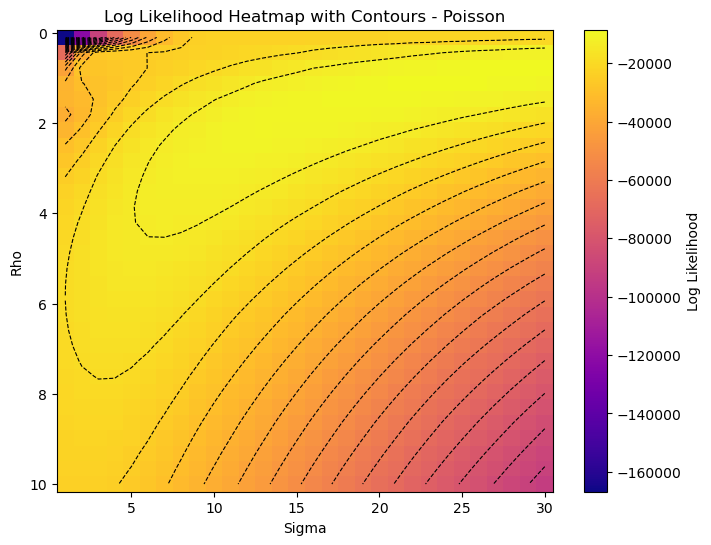

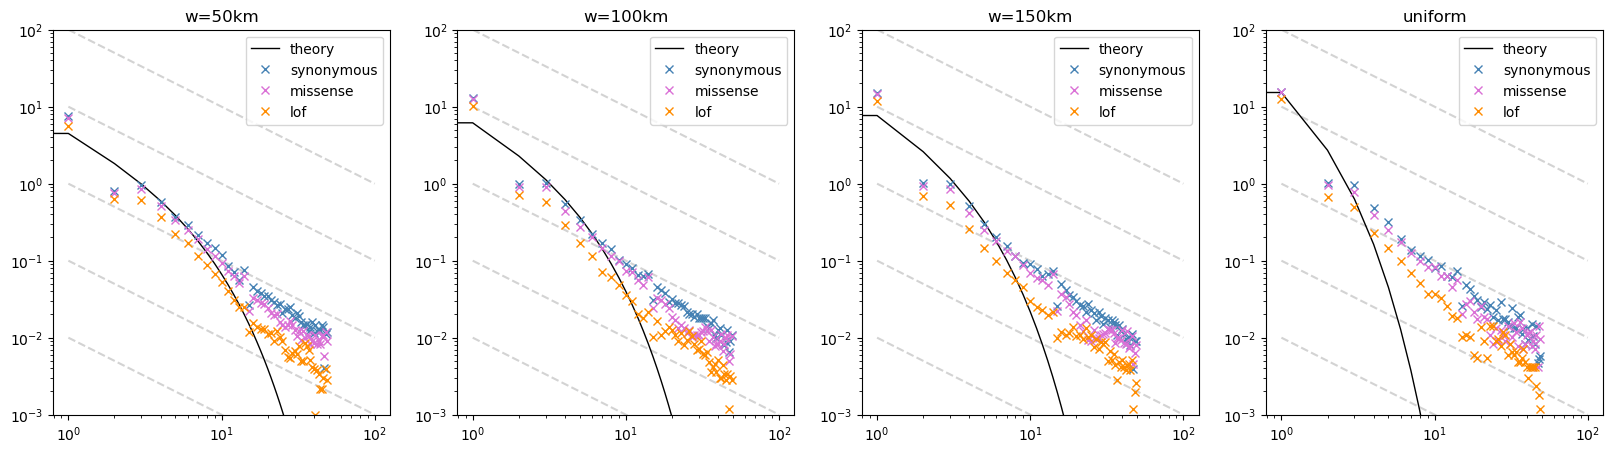

In [175]:
plot_log_likelihood_v2(res3_df1)
plot_data_vs_theory(30,0.78,0.005298)

### 2-10tons

In [50]:
res3_df2=pd.read_csv('res_w50_w100_w150_minx2.csv')
res3_df2

,sigma,rho,s,w,mu,logl
0,30.0,0.100000,0.002043,multi,1.250000e-08,-1.484396e+03
1,29.0,0.100000,0.002043,multi,1.250000e-08,-1.485374e+03
2,30.0,0.100000,0.002395,multi,1.250000e-08,-1.532470e+03
3,28.0,0.100000,0.002043,multi,1.250000e-08,-1.532755e+03
4,20.0,0.441379,0.005298,multi,1.250000e-08,-1.548301e+03
...,...,...,...,...,...,...
26995,29.0,9.658621,0.000100,multi,1.250000e-08,-2.455642e+06
26996,30.0,9.317241,0.000100,multi,1.250000e-08,-2.459716e+06
26997,29.0,10.000000,0.000100,multi,1.250000e-08,-2.462260e+06
26998,30.0,9.658621,0.000100,multi,1.250000e-08,-2.466447e+06


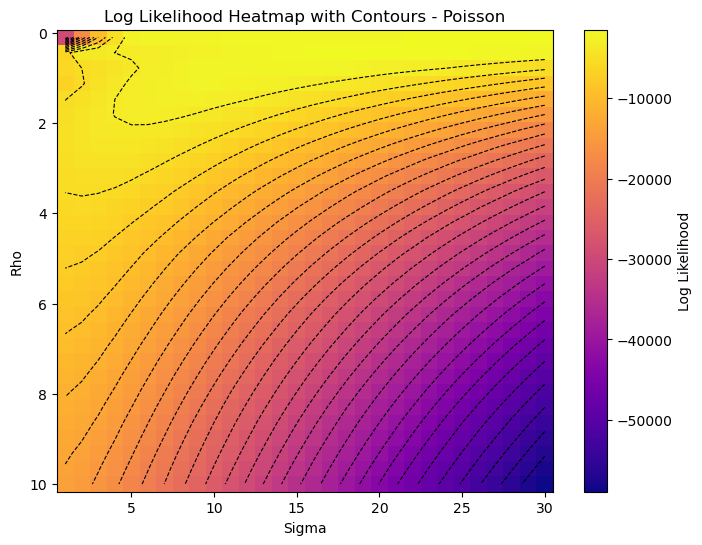

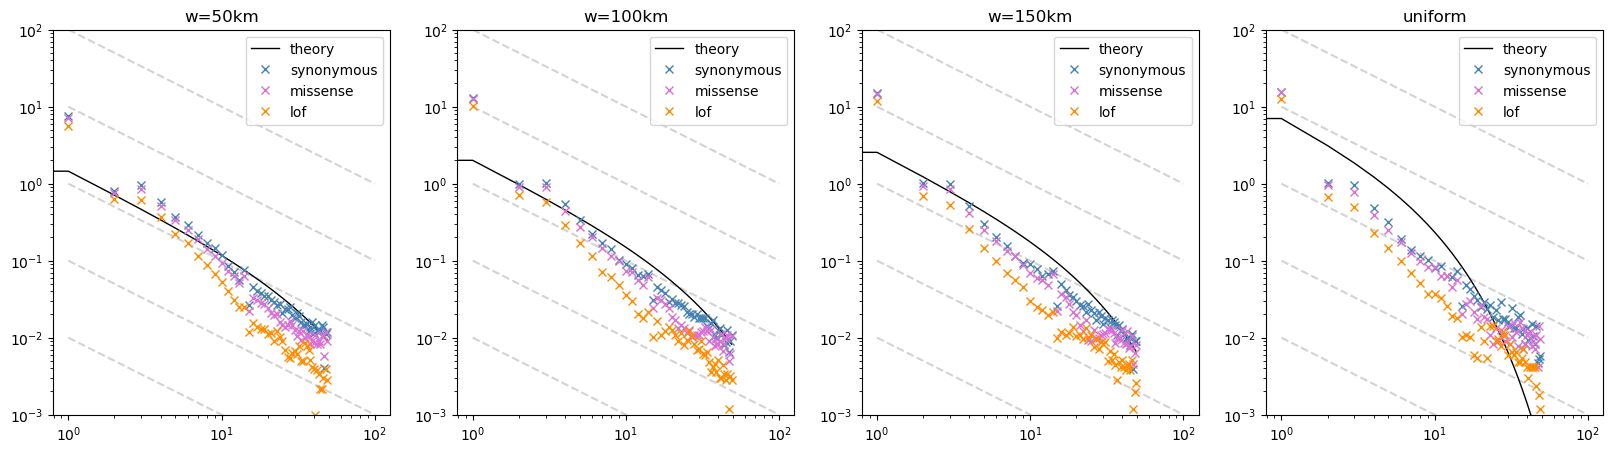

In [176]:
plot_log_likelihood_v2(res3_df2)
plot_data_vs_theory(30,0.1,0.002043)

### 3-10tons

In [81]:
res3_df3=pd.read_csv('res_w50_w100_w150_minx3.csv')
res3_df3

,sigma,rho,s,w,mu,logl
0,28.0,0.441379,0.005298,multi,1.250000e-08,-2.897566e+02
1,29.0,0.441379,0.005298,multi,1.250000e-08,-2.916018e+02
2,27.0,0.441379,0.005298,multi,1.250000e-08,-2.964133e+02
3,30.0,0.441379,0.005298,multi,1.250000e-08,-3.009820e+02
4,26.0,0.441379,0.005298,multi,1.250000e-08,-3.127119e+02
...,...,...,...,...,...,...
26995,28.0,4.196552,0.000100,multi,1.250000e-08,-1.233689e+06
26996,26.0,4.879310,0.000100,multi,1.250000e-08,-1.233701e+06
26997,27.0,4.537931,0.000100,multi,1.250000e-08,-1.233736e+06
26998,29.0,4.196552,0.000100,multi,1.250000e-08,-1.233793e+06


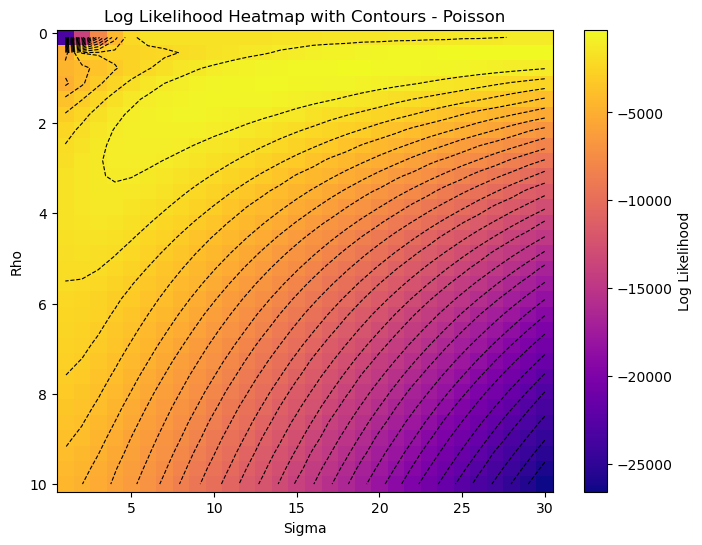

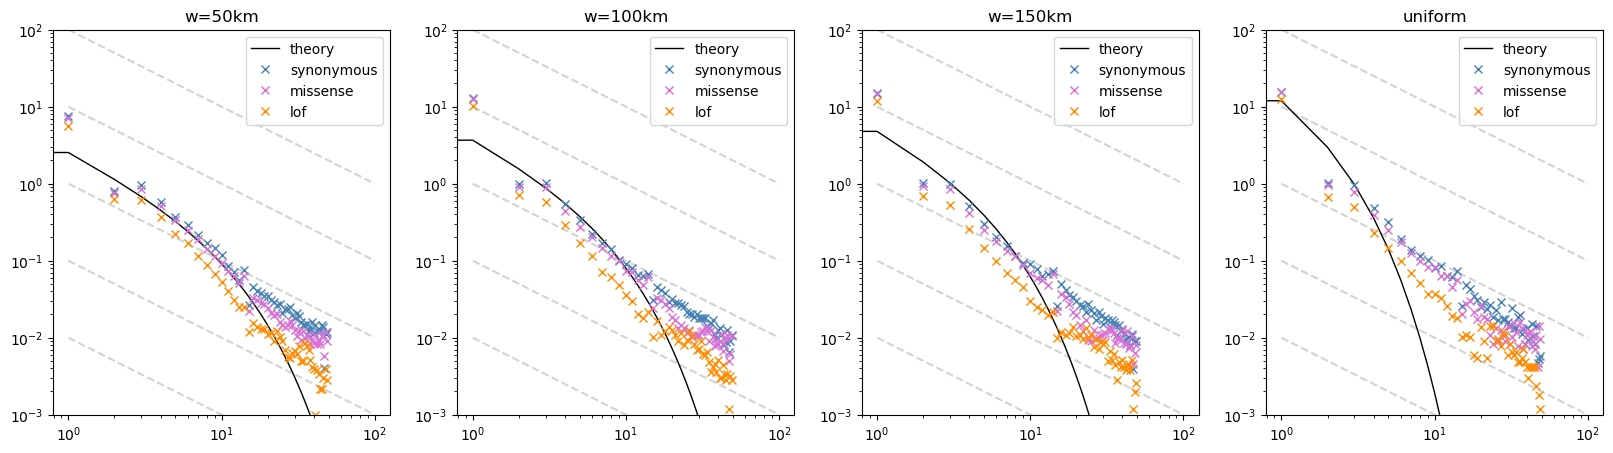

In [177]:
plot_log_likelihood_v2(res3_df3)
plot_data_vs_theory(28.0,0.441379,0.005298)